In [1]:
import os
from os.path import join
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing import image

np.random.seed(33)

In [2]:
PROJ_ROOT = os.pardir
data_dir = join(PROJ_ROOT, 'dataset')
train_folder = join(data_dir, 'train')
mask_folder = join(data_dir, 'train_masks')
train_imgs = os.listdir(train_folder)
mask_imgs = os.listdir(mask_folder)

In [3]:
print(len(train_imgs))
print(len(mask_imgs))

5088
5088


In [4]:
carvana_train = pd.read_csv(
    join(data_dir, 'train_masks.csv'), usecols=['img'])

carvana_train['img_id'] = carvana_train['img'].map(
    lambda row: row.split('.')[0])

In [5]:
def get_img_mask_arrays(img_id, input_size=256):
    # load into PIL format
    img = image.load_img(join(train_folder, '%s.jpg' % img_id),
                         target_size=(input_size, input_size))
    # convert to numpy array
    img = image.img_to_array(img)
    img = img / 255.
    mask = image.load_img(join(mask_folder, '%s_mask.gif' % img_id),
                          color_mode='grayscale', target_size=(
                              input_size, input_size))
    mask = image.img_to_array(mask)
    mask = mask / 255.
    return img, mask

def plot_img_mask(img, mask, input_size=256):
    fig, axs = plt.subplots(
        ncols=2, figsize=(10, 5), sharex=True, sharey=True)
    axs[0].imshow(img)
    axs[1].imshow(mask[:, :, 0])
    for ax in axs:
        ax.set_xlim(0, input_size)
        ax.axis('off')
    fig.tight_layout()
    plt.show()

(256, 256, 3) (256, 256, 1)


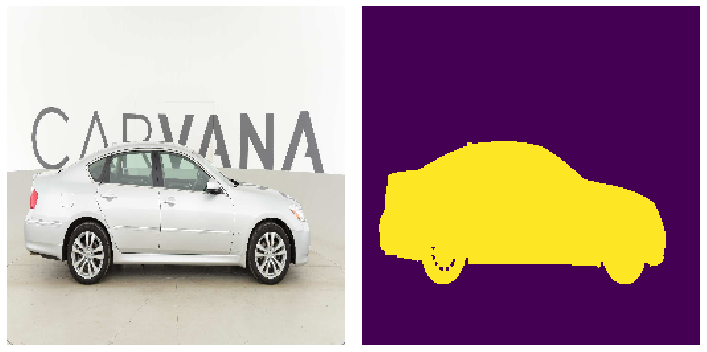

In [6]:
img_ids = carvana_train['img_id'].values
np.random.shuffle(img_ids)
img_id = img_ids[0]
img, mask = get_img_mask_arrays(img_id)
print(img.shape, mask.shape)
plot_img_mask(img, mask)